In [2]:
import pandas as pd
import math
import warnings
import yfinance as yf
import QuantLib as ql
from datetime import timedelta
from HestonModel import Heston, HestonPriceFunction
from Heston import HestonParameters, calculate_expected_variance_over_strikes
warnings.filterwarnings("ignore")


heston = Heston()
heston.load_data('Data/20230912_PLIQ_IP.csv')
heston.preprocess_data()
heston.clean['Spot'] = heston.clean.Futuro * (-heston.clean['Tasa de Interes'] * heston.clean['Plazo a Vencimiento']).apply(lambda x: math.exp(x))
heston.clean

,Fecha,TV,Emisora,Serie,Vencimiento,Tasa de Interes,Plazo a Vencimiento,Futuro,Pliq,Bid,Ask,Call o Put,Hubo Bid/Ask,Volatilidad,V. Teorico,Mes_vencimiento,Spot
0,2023-09-12,OI,IP,40000,C,0.119300,0.513889,53969,15676.0,0.0,0.0,0,0,0.587818,15676.291368,3,50759.706626
1,2023-09-12,OI,IP,40500,C,0.119300,0.513889,53969,15295.0,0.0,0.0,0,0,0.581875,15294.629056,3,50759.706626
2,2023-09-12,OI,IP,41000,C,0.119300,0.513889,53969,14915.0,0.0,0.0,0,0,0.575899,14914.803711,3,50759.706626
3,2023-09-12,OI,IP,41500,C,0.119300,0.513889,53969,14537.0,0.0,0.0,0,0,0.569911,14537.058921,3,50759.706626
4,2023-09-12,OI,IP,42000,C,0.119300,0.513889,53969,14161.0,0.0,0.0,0,0,0.563888,14161.207052,3,50759.706626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2023-09-12,OI,IP,68000,X,0.116797,0.261111,52515,15685.0,0.0,0.0,1,0,0.417201,15685.461471,12,50937.625186
484,2023-09-12,OI,IP,68500,X,0.116797,0.261111,52515,16165.0,0.0,0.0,1,0,0.424280,16165.480807,12,50937.625186
485,2023-09-12,OI,IP,69000,X,0.116797,0.261111,52515,16646.0,0.0,0.0,1,0,0.431235,16645.517159,12,50937.625186
486,2023-09-12,OI,IP,69500,X,0.116797,0.261111,52515,17126.0,0.0,0.0,1,0,0.438069,17125.566692,12,50937.625186


In [3]:
import pandas as pd
import math
import warnings
import yfinance as yf
import QuantLib as ql
from datetime import timedelta
from HestonModel import Heston, HestonPriceFunction
#from V4 import HestonParameters, get_metrics, calculate_expected_variance_over_strikes
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
warnings.filterwarnings("ignore")

In [7]:
pd.to_datetime(heston.option.lastTradeDate.iloc[1]) + timedelta(days=1)

Timestamp('2023-11-04 00:00:00')

In [3]:
from HestonVolatilitiesUI import HestonModule
from Heston import HestonParameters, calculate_expected_variance_over_strikes, to_ql_dates, get_prices_with_fill
from datetime import timedelta
import pandas as pd
heston = HestonModule('AAPL')
heston.get_dividend(0)
heston.opt_type("Call")
results = heston.get_results()
#robust_sim = heston.gpt_sim()

In [4]:
option = heston.option.copy()
option = option[option['lastTradeDate'] == option['lastTradeDate'].mode()[0]]
trade_dates = option['lastTradeDate']
start_date, end_date = trade_dates.min(), trade_dates.max()
end_date = end_date + timedelta(days=1)

# Use get_prices_with_fill to ensure we have a price for each date
prices = get_prices_with_fill(heston.ticker_symbol, start_date, end_date)

# Ensure that the data types are correct after merging
option['lastTradeDate'] = pd.to_datetime(option['lastTradeDate'])
prices['Date'] = pd.to_datetime(prices['Date'])

# Merge the data on dates ensuring all dates up to maturity have a price
option = option.merge(prices, left_on='lastTradeDate', right_on='Date', how='left').drop('Date', axis=1).rename(columns={'Adj Close': 'Price'})
option['lastTradeDate'] = option['lastTradeDate'].apply(to_ql_dates)
option['Maturity'] = option['Maturity'].apply(to_ql_dates)

# ... rest of the processing and Heston parameter calculations

sim_until_maturity = pd.DataFrame()

# Iterate through each row in the option DataFrame
for index, row in option.iterrows():
    # Extract data for this particular option
    spot_price = row['Price']
    strike_price = row['strike']
    market_price = row['lastPrice']
    historical_volatility = row['impliedVolatility']
    calculation_date = row['lastTradeDate']
    maturity_date = row['Maturity']
    ttm = row['TTM']

    # Calculate Heston parameters for this option
    heston_params = HestonParameters(spot_price, strike_price, market_price, heston.dividend, [.1, .1, historical_volatility, .1, .1], calculation_date, maturity_date, ttm, call_option=heston.call_option)
    
    # Combine the results
    sim_until_maturity = pd.concat([sim_until_maturity, heston_params], axis=0)

# Calculate expected variance over strikes for the combined results
heston.sim_until_maturity = calculate_expected_variance_over_strikes(sim_until_maturity)

TypeError: can only concatenate str (not "datetime.timedelta") to str

In [2]:
robust_sim

,Strike,TTM,Estimated_Price,Market_Price,v0,kappa,theta,sigma,rho,Expected_Variance


In [5]:
heston.option['lastTradeDate'].mode()[0]

'2023-11-03'

In [31]:
results.columns

Index(['Strike', 'TTM', 'Estimated_Price', 'Market_Price', 'v0', 'kappa',
       'theta', 'sigma', 'rho', 'Expected_Variance'],
      dtype='object')

In [6]:
from Heston import HestonParameters

In [7]:
from Heston import HestonParameters, get_metrics, calculate_expected_variance_over_strikes, to_ql_dates, simple_plot
from HestonModel import Heston, HestonPriceFunction
from datetime import timedelta
import yfinance as yf
import QuantLib as ql
import pandas as pd
import numpy as np
import warnings
import math

ticker_symbol = 'AAPL' # Will be provided by user
call_or_put = 'Call' # Will be provided by user

ticker_data = yf.Ticker(ticker_symbol)
options_expirations = ticker_data.options
expiration_date = options_expirations[2]
options_chain = ticker_data.option_chain(expiration_date)

if call_or_put == 'Call':
    option = options_chain.calls
elif call_or_put == 'Put':
    option = options_chain.puts

option = option.dropna()
option = option[option['volume']  > 10]
option['Maturity'] = expiration_date
option['Maturity'] = pd.to_datetime(option['Maturity'])
option['lastTradeDate'] = pd.to_datetime(option['lastTradeDate']).dt.tz_localize(None)
option['TTM'] = (pd.to_datetime(option['Maturity']) - option['lastTradeDate']).dt.days / 365.0

trade_dates = option['lastTradeDate']
start_date, end_date = trade_dates.min(), trade_dates.max()
end_date = end_date + timedelta(days = 1)
prices = yf.download(ticker_symbol, start = start_date, end = end_date, progress = False)['Adj Close'].reset_index()
option['lastTradeDate'] = option['lastTradeDate'].apply(lambda x: x.strftime('%Y-%m-%d'))
prices['Date'] = prices['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
option = option.merge(prices, left_on = 'lastTradeDate', right_on = 'Date', how = 'left').drop('Date', axis = 1).rename( columns = {'Adj Close':'Price'})
option['lastTradeDate'] = option['lastTradeDate'].apply(to_ql_dates)
option['Maturity'] = option['Maturity'].apply(to_ql_dates)

spots = option['Price'].values
strikes = option['strike'].values
mkts = option['lastPrice'].values
dividend = .00
vols = option['impliedVolatility'].values
calc = option['lastTradeDate'].values
maturities = option['Maturity'].values
ttms = option['TTM'].values

results = [HestonParameters(spot_price, strike_price, market_price, dividend, [.1, .1, historical_volatility, .1, .1], calculation_date, maturity_date, ttm) for 
spot_price, strike_price, market_price, historical_volatility, calculation_date, maturity_date, ttm in zip(spots, strikes, mkts, vols, calc, maturities, ttms)]

In [8]:
get_metrics(results) # Calculation Metrics

,Success,MSE
Optimizer,,
TNC,200.0%,6.291197


<Axes: xlabel='strike'>

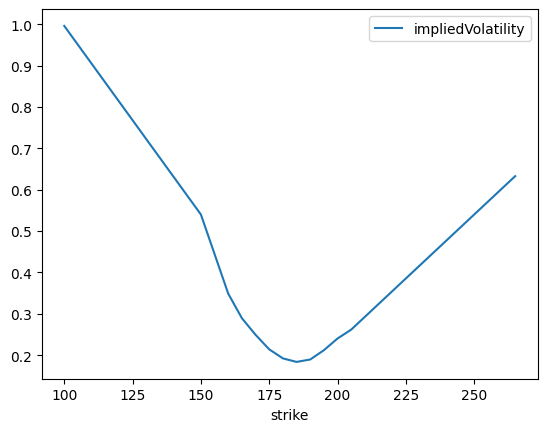

In [5]:
calls[['strike','impliedVolatility']].set_index('strike').plot()